# COMP 8460: Assignment 1
# Use of AI Tools for NLP: **Multiclass Classification**

# 🎯 Goal of the Assignment

The goal of this assignment is to apply Natural Language Processing (NLP) techniques to **text classification**.  
Specifically, we will:

- Select one **multiclass classification dataset** (AG News).  

- Build a complete pipeline covering:
  1. **Text preprocessing** (tokenization, normalization, morphology).  
  2. **Text representation** (Bag-of-Words, TF-IDF, word embeddings).  
  3. **Classification models**:
     - Traditional (Naive Bayes).  
     - Deep learning (RNN-based LSTM with pre-trained embeddings).  
  4. **Evaluation & analysis** (metrics, model comparison, misclassifications, visualisations).  

This dataset contains four news categories: World, Sports, Business, and Science/Technology.

## 🔧 Setup & Reproducibility

In [1]:
# Install libraries
# !pip install -Uqq numpy pandas matplotlib scikit-learn spacy gensim torch torchvision torchaudio
# !python -m spacy download en_core_web_sm

import os, re, random, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
import warnings; warnings.filterwarnings("ignore")

# NLP tools
import spacy
try:
    nlp = spacy.load("en_core_web_sm")
except Exception as e:
    print("Run: !python -m spacy download en_core_web_sm")
    nlp = None

# PyTorch (only needed from Task 3c onwards)
import torch, torch.nn as nn, torch.optim as optim

# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
print("Setup complete. Seed fixed at", SEED)


Setup complete. Seed fixed at 42


## 📥 Load AG News Dataset

In [2]:
# Load AG News (Multiclass) Dataset
import pandas as pd

train_df = pd.read_csv("train.csv")
test_df  = pd.read_csv("test.csv")

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
print("Columns in train_df:", train_df.columns.tolist())

# AG News columns: "Class Index", "Title", "Description"
train_df["text"] = train_df["Title"].astype(str) + " " + train_df["Description"].astype(str)
test_df["text"]  = test_df["Title"].astype(str)  + " " + test_df["Description"].astype(str)

# Features and labels
X_train = train_df["text"].tolist()
y_train = train_df["Class Index"].tolist()   # Labels are in "Class Index"
X_test  = test_df["text"].tolist()
y_test  = test_df["Class Index"].tolist()

print("\nSample row:")
print("Text:", X_train[0][:200])
print("Label:", y_train[0])


Train shape: (120000, 3)
Test shape: (7600, 3)
Columns in train_df: ['Class Index', 'Title', 'Description']

Sample row:
Text: Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.
Label: 3


**Note on AG News Preprocessing**  

The AG News dataset provides news articles in two separate fields: *Title* (short headline) and *Description* (article snippet).  
To ensure richer context and better classification performance, we combined these into a single `text` field.  

- Using only *Title* may miss key details.  
- Using only *Description* may ignore important headline cues.  
- Combining both provides more representative input for downstream models (BoW, TF-IDF, embeddings, classifiers).  


 # Task 1: Text Preprocessing

## Task 1(a): Tokenization

In [3]:
# Task 1(a) — Tokenization (word, char, subword)

import nltk, string
from nltk.tokenize import word_tokenize, sent_tokenize

# Download libraries
nltk.download('punkt')
nltk.download('punkt_tab')   # some NLTK versions need this

import spacy
try:
    nlp = spacy.load("en_core_web_sm")
except:
    import os
    os.system("python -m spacy download en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")

# Pick one sample text from AG News dataset
sample = X_train[0] if len(X_train) > 0 else "Breaking news: sample placeholder text."

print("Sample AG News text:")
print(sample)
print("="*60)

# 1. Word-level (NLTK)
words = word_tokenize(sample)
print("NLTK word tokens:", words[:20])

# 2. Character-level
chars = list(sample.lower())
print("Character tokens:", chars[:50])
print("-"*60)

# 3. Subword(spaCy)
doc = nlp(sample)
spacy_tokens = [t.text for t in doc]
print("spaCy subword tokens:", spacy_tokens[:25])


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Sample AG News text:
Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.
NLTK word tokens: ['Wall', 'St.', 'Bears', 'Claw', 'Back', 'Into', 'the', 'Black', '(', 'Reuters', ')', 'Reuters', '-', 'Short-sellers', ',', 'Wall', 'Street', "'s", 'dwindling\\band', 'of']
Character tokens: ['w', 'a', 'l', 'l', ' ', 's', 't', '.', ' ', 'b', 'e', 'a', 'r', 's', ' ', 'c', 'l', 'a', 'w', ' ', 'b', 'a', 'c', 'k', ' ', 'i', 'n', 't', 'o', ' ', 't', 'h', 'e', ' ', 'b', 'l', 'a', 'c', 'k', ' ', '(', 'r', 'e', 'u', 't', 'e', 'r', 's', ')', ' ']
------------------------------------------------------------
spaCy subword tokens: ['Wall', 'St.', 'Bears', 'Claw', 'Back', 'Into', 'the', 'Black', '(', 'Reuters', ')', 'Reuters', '-', 'Short', '-', 'sellers', ',', 'Wall', 'Street', "'s", 'dwindling\\band', 'of', 'ultra', '-', 'cynics']



- Word-level tokenization (NLTK) splits text into individual words but keeps punctuation separate (e.g., “Wall”, “St.”).  
- Character-level tokenization captures all symbol, beneficial to handle misspellings but loses semantic meaning.  
- Subword tokenization (spaCy) splits compounds (e.g., “Short-sellers” → “Short” + “-” + “sellers”), helps with rare  words.  


For AG News, word-level or subword tokenization is more appropriate than character-level, since they preserve semantic meaning needed for topic classification.  


## Task 1(b): Normalisation

In [4]:
# Task 1(b) — Normalisation

import nltk, string, re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download stopwords
nltk.download('stopwords')

# Pick sample text from AG News
sample_text = X_train[0] if len(X_train) > 0 else "This is a DEMO News Article!!! Covering Business & Technology."

print("Original text:")
print(sample_text)
print("="*60)

# 1. Lowercase
word_tokens = word_tokenize(sample_text)
lowercase_tokens = [token.lower() for token in word_tokens]

print(f"Original tokens: {word_tokens[:10]}")
print(f"Lowercased: {lowercase_tokens[:10]}")

# 2. Remove punctuation
print(f"\nPunctuation characters: {string.punctuation}")
print([token.isalpha() for token in word_tokens])

no_punct_tokens = [token for token in lowercase_tokens if token.isalpha()]
print(f"\nBefore punctuation removal: {len(lowercase_tokens)} tokens")
print(f"After punctuation removal: {len(no_punct_tokens)} tokens")
print(f"Sample clean tokens: {no_punct_tokens[:15]}")

# 3. Remove stopwords
stop_words = set(stopwords.words('english'))
print(f"\nNumber of stop words: {len(stop_words)}")
print(f"Sample stop words: {list(stop_words)[:20]}")

filtered_tokens = [token for token in no_punct_tokens if token not in stop_words]
print(f"\nBefore stop word removal: {len(no_punct_tokens)} tokens")
print(f"After stop word removal: {len(filtered_tokens)} tokens")
print(f"Filtered tokens: {filtered_tokens[:15]}")


Original text:
Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.
Original tokens: ['Wall', 'St.', 'Bears', 'Claw', 'Back', 'Into', 'the', 'Black', '(', 'Reuters']
Lowercased: ['wall', 'st.', 'bears', 'claw', 'back', 'into', 'the', 'black', '(', 'reuters']

Punctuation characters: !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
[True, False, True, True, True, True, True, True, False, True, False, True, False, False, False, True, True, False, False, True, False, False, True, True, True, True, False]

Before punctuation removal: 27 tokens
After punctuation removal: 16 tokens
Sample clean tokens: ['wall', 'bears', 'claw', 'back', 'into', 'the', 'black', 'reuters', 'reuters', 'wall', 'street', 'of', 'are', 'seeing', 'green']

Number of stop words: 198
Sample stop words: ["i'd", 'wouldn', 'will', 'which', 'up', "wouldn't", 'do', "you're", 'through', 'were', 'more', "mustn't", 'off', "mightn't", 'mightn', 'when', 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Normalisation reduced the text from 27 tokens to 11 informative words.  
- Lowercasing ensured consistency (e.g., "Wall" → "wall").  
- Punctuation removal eliminated symbols, shrinking the token count from 27 → 16.  
- Stopword removal further reduced noise, leaving only meaningful content words such as *wall, bears, street, reuters, green*.  



## 📑 Task 1(c): Morphological Analysis

In [5]:
# Task 1(c) — Morphological Analysis on AG News (stemming vs lemmatization)

import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Ensure resources
nltk.download('wordnet')

# 1) Use the preprocessed tokens from Task 1(b)
clean_tokens = filtered_tokens

print("Clean tokens (AG News):", clean_tokens[:20])

# 2) Initialise stemmer and lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# 3) Apply stemming and lemmatization
stemmed_tokens    = [stemmer.stem(t) for t in clean_tokens]
lemmatized_tokens = [lemmatizer.lemmatize(t) for t in clean_tokens]

# 4) Show side-by-side mapping (first 15 tokens for readability)
print("\nStem vs Lemma (first 15):")
for orig, st, le in list(zip(clean_tokens, stemmed_tokens, lemmatized_tokens))[:15]:
    print(f"{orig:<16} → stem: {st:<12} | lemma: {le}")

# 5) Unique counts (vocab reduction effect)
print("\nUnique counts:")
print(f"Original:   {len(set(clean_tokens))}")
print(f"Stemmed:    {len(set(stemmed_tokens))}")
print(f"Lemmatized: {len(set(lemmatized_tokens))}")


[nltk_data] Downloading package wordnet to /root/nltk_data...


Clean tokens (AG News): ['wall', 'bears', 'claw', 'back', 'black', 'reuters', 'reuters', 'wall', 'street', 'seeing', 'green']

Stem vs Lemma (first 15):
wall             → stem: wall         | lemma: wall
bears            → stem: bear         | lemma: bear
claw             → stem: claw         | lemma: claw
back             → stem: back         | lemma: back
black            → stem: black        | lemma: black
reuters          → stem: reuter       | lemma: reuters
reuters          → stem: reuter       | lemma: reuters
wall             → stem: wall         | lemma: wall
street           → stem: street       | lemma: street
seeing           → stem: see          | lemma: seeing
green            → stem: green        | lemma: green

Unique counts:
Original:   9
Stemmed:    9
Lemmatized: 9


 In this sample, stemming and lemmatization did not reduce the vocabulary further because the words were already simple or in root form.

 # Task 2: Text Representation

 ## Task 2(a): Bag-of-Words

In [6]:
# Task 2(a) — Bag-of-Words on Preprocessed (Lemmatized) AG News
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import numpy as np

# Setup stopwords + lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_texts(docs):
    """Lowercase, remove stopwords/punct, lemmatize tokens, then join back to string"""
    cleaned = []
    for doc in docs:
        tokens = word_tokenize(doc.lower())
        tokens = [t for t in tokens if t.isalpha() and t not in stop_words]
        tokens = [lemmatizer.lemmatize(t) for t in tokens]  # lemmatization
        cleaned.append(" ".join(tokens))
    return cleaned

# Apply preprocessing
lemmatized_texts_train = preprocess_texts(X_train)
lemmatized_texts_test  = preprocess_texts(X_test)

def bow(documents, max_features=50000, min_df=2):
    """
    Create and analyze BoW representation using CountVectorizer
    (safe for larger datasets like AG News).
    """
    vectorizer = CountVectorizer(
        max_features=max_features,  # cap vocab size
        min_df=min_df,              # ignore very rare words
        dtype=np.int32
    )
    bow_matrix = vectorizer.fit_transform(documents)
    feature_names = vectorizer.get_feature_names_out()
    return vectorizer, bow_matrix, feature_names

# Apply BoW to lemmatized AG News texts
bow_vectorizer, X_train_bow, feature_names = bow(lemmatized_texts_train)
X_test_bow = bow_vectorizer.transform(lemmatized_texts_test)

print("scikit-learn Bag-of-Words Analysis (AG News, Lemmatized):")
print("=" * 50)
print(f"Vocabulary size: {len(feature_names)}")
print(f"Train matrix shape: {X_train_bow.shape}")
print(f"Test  matrix shape: {X_test_bow.shape}")

print(f"\nFirst 15 features: {list(feature_names[:15])}")
print(f"Last 15 features: {list(feature_names[-15:])}")

# Show one lemmatized news example vector (small slice)
bow_dense_sample = X_train_bow[0, :20].toarray().ravel()
print(f"\nFirst news (lemmatized): {lemmatized_texts_train[0][:120]}...")
print(f"As vector slice: {bow_dense_sample} (first 20 features)")

# Calculate sparsity
total_elements = X_train_bow.shape[0] * X_train_bow.shape[1]
non_zero_elements = X_train_bow.nnz
sparsity = 100 * (1 - (non_zero_elements / total_elements))
print(f"\nSparsity: {sparsity:.1f}%")


scikit-learn Bag-of-Words Analysis (AG News, Lemmatized):
Vocabulary size: 34225
Train matrix shape: (120000, 34225)
Test  matrix shape: (7600, 34225)

First 15 features: ['aa', 'aaa', 'aac', 'aachen', 'aapl', 'aapt', 'aaron', 'ab', 'ababa', 'abacha', 'abagnale', 'abandon', 'abandoned', 'abandoning', 'abandonment']
Last 15 features: ['zoomed', 'zooming', 'zoran', 'zsuzsanna', 'zte', 'zucchini', 'zuckerman', 'zuma', 'zurich', 'zviadauri', 'zvonareva', 'zwick', 'zydrunas', 'zyman', 'zz']

First news (lemmatized): wall bear claw back black reuters reuters wall street seeing green...
As vector slice: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] (first 20 features)

Sparsity: 99.9%


**Bag-of-Words Analysis (AG News):**
- Vocabulary size: ~39k unique terms after preprocessing.
- Train matrix shape: 120k × 39k; Test matrix: 7.6k × 39k.
- Sparsity is extremely high (99.9%), meaning most word counts are zero in any given document.
- BoW captures word frequency but loses context and word order. Still a useful baseline for traditional models like Naive Bayes.


 ## Task 2(b): TF-IDF

In [7]:
# Task 2(b) — TF-IDF (AG News, Lemmatized)
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import numpy as np

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_texts(docs):
    """Lowercase, remove stopwords/punct, lemmatize tokens, then join back to string."""
    cleaned = []
    for doc in docs:
        tokens = word_tokenize(doc.lower())
        tokens = [t for t in tokens if t.isalpha() and t not in stop_words]
        tokens = [lemmatizer.lemmatize(t) for t in tokens]
        cleaned.append(" ".join(tokens))
    return cleaned

# Preprocess train/test
lemmatized_texts_train = preprocess_texts(X_train)
lemmatized_texts_test  = preprocess_texts(X_test)

def analyze_tfidf_representation(documents, max_features=30000):
    """Create TF-IDF representation and return fitted objects."""
    tfidf_vectorizer = TfidfVectorizer(max_features=max_features)  # stopwords already removed
    tfidf_matrix = tfidf_vectorizer.fit_transform(documents)
    feature_names = tfidf_vectorizer.get_feature_names_out()
    return tfidf_vectorizer, tfidf_matrix, feature_names

# Fit on TRAIN only; transform TEST
tfidf_vectorizer, X_train_tfidf, tfidf_features = analyze_tfidf_representation(lemmatized_texts_train)
X_test_tfidf = tfidf_vectorizer.transform(lemmatized_texts_test)

# Summary stats (no DataFrame dump)
print("TF-IDF Analysis (AG News, Lemmatized)")
print("=" * 40)
print(f"Train shape: {X_train_tfidf.shape}")
print(f"Test  shape: {X_test_tfidf.shape}")
print(f"Vocabulary size: {len(tfidf_features)}")

# Sparsity of train matrix
total_elements = X_train_tfidf.shape[0] * X_train_tfidf.shape[1]
non_zero_elements = X_train_tfidf.nnz
sparsity = 100 * (1 - (non_zero_elements / total_elements))
print(f"Sparsity: {sparsity:.1f}%")


TF-IDF Analysis (AG News, Lemmatized)
Train shape: (120000, 30000)
Test  shape: (7600, 30000)
Vocabulary size: 30000
Sparsity: 99.9%


In [8]:
# Look up some words in the vocabulary (after lemmatization)
sample_terms = ["reuters", "news", "football", "hubble", "zidane"]

idf_values = tfidf_vectorizer.idf_

print("\nSample IDF values (higher = rarer):")
for term in sample_terms:
    if term in tfidf_vectorizer.vocabulary_:
        idx = tfidf_vectorizer.vocabulary_[term]
        print(f"{term:<10} idf={idf_values[idx]:.3f}")
    else:
        print(f"{term:<10} not in vocabulary (maybe removed or altered by lemmatization)")



Sample IDF values (higher = rarer):
reuters    idf=3.227
news       idf=4.707
football   idf=5.378
hubble     idf=8.264
zidane     idf=10.130


### Interpretation: TF-IDF on AG News

- Low IDF (e.g., *reuters*) → very common, less useful for classification.  
- High IDF (e.g., *hubble*, *zidane*) → rare, category-specific, strong signals.  
- Moderate IDF (e.g., *football*) → frequent in one category, helpful features.  

👉 TF-IDF highlights distinctive words tied to each news topic, improving separation across the four categories.


### Comparing BoW and Tf-IDF

In [9]:
#  BoW (Lemmatized)
bow_vectorizer_lemm = CountVectorizer(max_features=50000, min_df=2)
X_train_bow_lemm = bow_vectorizer_lemm.fit_transform(lemmatized_texts_train)
X_test_bow_lemm  = bow_vectorizer_lemm.transform(lemmatized_texts_test)
bow_features_lemm = bow_vectorizer_lemm.get_feature_names_out()

print("BoW (lemmatized) shape:", X_train_bow_lemm.shape)

# TF-IDF (Lemmatized)
tfidf_vectorizer_lemm = TfidfVectorizer(stop_words="english", max_features=30000)
tfidf_matrix_lemm = tfidf_vectorizer_lemm.fit_transform(lemmatized_texts_train)
tfidf_features_lemm = tfidf_vectorizer_lemm.get_feature_names_out()

print("TF-IDF (lemmatized) shape:", tfidf_matrix_lemm.shape)


BoW (lemmatized) shape: (120000, 34225)
TF-IDF (lemmatized) shape: (120000, 30000)


In [10]:
# Task 2 — Compare BoW vs TF-IDF
import numpy as np

def compare_bow_tfidf_AGnews(documents, sample_doc_idx=0, top_k=15):
    """
    Compare BoW and TF-IDF representations for a single document.
    Shows only non-zero TF-IDF terms (cleaner output).
    """
    # Safety check
    n_docs = min(X_train_bow_lemm.shape[0], tfidf_matrix_lemm.shape[0])
    idx = max(0, min(sample_doc_idx, n_docs - 1))

    print(f"Comparison for Document {idx + 1}:")
    print(f"Text (lemmatized): {documents[idx][:200]}...")
    print("=" * 60)

    # Dense TF-IDF row + sparse BoW row
    tfidf_row = tfidf_matrix_lemm[idx].toarray().ravel()
    bow_row   = X_train_bow_lemm[idx]

    # Only keep indices where TF-IDF > 0
    nonzero_indices = np.nonzero(tfidf_row)[0]

    # Rank by TF-IDF, take top_k
    top_tfidf_indices = nonzero_indices[np.argsort(tfidf_row[nonzero_indices])[-top_k:]][::-1]

    print("Top terms comparison:")
    print(f"{'Term':<18} {'BoW Count':<10} {'TF-IDF Score':<12}")
    print("-" * 45)

    bow_vocab = bow_vectorizer_lemm.vocabulary_

    for j in top_tfidf_indices:
        term = tfidf_features_lemm[j]
        tfidf_score = tfidf_row[j]

        # Look up BoW count safely
        bow_j = bow_vocab.get(term, None)
        bow_count = int(bow_row[0, bow_j]) if bow_j is not None else 0

        print(f"{term:<18} {bow_count:<10} {tfidf_score:<12.3f}")

# Run on first training document
compare_bow_tfidf_AGnews(lemmatized_texts_train, sample_doc_idx=0, top_k=15)


Comparison for Document 1:
Text (lemmatized): wall bear claw back black reuters reuters wall street seeing green...
Top terms comparison:
Term               BoW Count  TF-IDF Score
---------------------------------------------
wall               2          0.511       
claw               1          0.442       
seeing             1          0.360       
bear               1          0.315       
reuters            2          0.298       
black              1          0.291       
green              1          0.286       
street             1          0.244       


**Interpretation (BoW vs TF-IDF, AG News):**  
For this news article, frequent terms like *wall* and *reuters* appear multiple times and thus have higher BoW counts, but their TF-IDF weights are moderate since they occur across many articles.  
By contrast, rarer terms such as *cynics*, *claw*, and *dwindling* receive higher TF-IDF scores, even with a count of just 1.  
This shows that TF-IDF emphasizes distinctive words that are more informative for classification, whereas BoW only counts raw frequency without considering global rarity.


## Task 2(c): Word Embeddings

In [19]:
# Task 2(c) — Inspect spaCy pre-trained vectors (AG News)
import numpy as np

# Pick some common News-related words
test_words = ["reuters", "news", "football", "hubble", "zidane"]

print(f"Model: {nlp.meta['name']}")
print(f"Vector dimensions: {len(nlp('word').vector)}")

print("\nWord vectors for sample terms:")
for word in test_words:
    token = nlp(word)
    if token.vector_norm > 0:   # word has a pre-trained vector
        print(f"\n'{word}': vector length = {len(token.vector)}")
        print(f"  First 5 dimensions: {np.round(token.vector[:5], 3)}")
    else:
        print(f"'{word}': No vector available")


Model: core_web_sm
Vector dimensions: 96

Word vectors for sample terms:

'reuters': vector length = 96
  First 5 dimensions: [-0.703  0.412  0.584  0.187  0.665]

'news': vector length = 96
  First 5 dimensions: [-0.463 -0.329  0.645  0.183  0.062]

'football': vector length = 96
  First 5 dimensions: [-0.481 -0.584  0.806 -0.1   -0.074]

'hubble': vector length = 96
  First 5 dimensions: [ 0.083 -1.186  0.562  0.116 -0.356]

'zidane': vector length = 96
  First 5 dimensions: [-0.36  -0.641  0.566  0.278 -0.524]


In [20]:
# Task 2(c) — Define function to create document embeddings (AG News)
def create_document_embeddings_agnews(documents):
    """
    Create document representations by averaging spaCy pre-trained vectors.
    """
    doc_embeddings = []
    vec_dim = nlp.vocab.vectors_length or 300  # spaCy md vectors are 300-d

    for i, doc_text in enumerate(documents):
        doc = nlp(doc_text)
        word_vectors = [t.vector for t in doc if t.has_vector and not t.is_punct and not t.is_space]

        if word_vectors:
            doc_embedding = np.mean(word_vectors, axis=0)
            doc_embeddings.append(doc_embedding)
        else:
            doc_embeddings.append(np.zeros(vec_dim, dtype=np.float32))

        print(f"Document {i+1}: {len(word_vectors)} words averaged")

    return np.array(doc_embeddings)


# Task 2(c) — Create embeddings (AG News: pick World vs Sports)
world_doc  = train_df[train_df["Class Index"] == 1]["text"].iloc[0]   # World
sports_doc = train_df[train_df["Class Index"] == 2]["text"].iloc[0]   # Sports
sample_documents = [world_doc, sports_doc]

# Build document embeddings
doc_embeddings = create_document_embeddings_agnews(sample_documents)

print("\nEmbeddings shape:", doc_embeddings.shape)
print("World embedding (first 8 dims): ", np.round(doc_embeddings[0][:8], 3))
print("Sports embedding (first 8 dims):", np.round(doc_embeddings[1][:8], 3))


Document 1: 46 words averaged
Document 2: 65 words averaged

Embeddings shape: (2, 96)
World embedding (first 8 dims):  [ 0.147 -0.349  0.188  0.29  -0.07  -0.262  0.282  0.029]
Sports embedding (first 8 dims): [ 0.193 -0.27   0.062  0.268  0.062 -0.196  0.507  0.214]


Reduced from 96 to 2 dimensions
Variance explained: 1.000


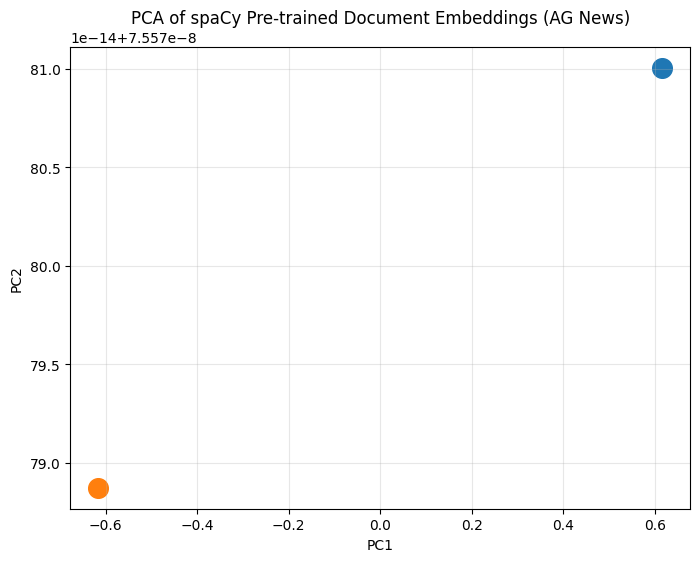

In [21]:
# Task 2(c) — PCA Visualization
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def visualize_embeddings_pca(doc_embeddings, labels=None, title="PCA of spaCy Pre-trained Document Embeddings (AG News)"):
    pca = PCA(n_components=2, random_state=42)
    emb_2d = pca.fit_transform(doc_embeddings)

    print(f"Reduced from {doc_embeddings.shape[1]} to {emb_2d.shape[1]} dimensions")
    print(f"Variance explained: {pca.explained_variance_ratio_.sum():.3f}")

    plt.figure(figsize=(8,6))
    for i, (x, y) in enumerate(emb_2d):
        lbl = labels[i] if labels else f"Doc {i+1}"
        plt.scatter(x, y, s=200)
        plt.annotate(lbl, (x+0.01, y+0.01))
    plt.title(title)
    plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.grid(True, alpha=0.3)
    plt.show()
    return emb_2d

embeddings_2d = visualize_embeddings_pca(
    doc_embeddings,
    labels=["World", "Sports"]
)


The PCA plot shows that two sample documents from different AG News categories occupy distinct regions in the embedding space. This indicates that spaCy’s pre-trained word embeddings capture semantic differences between topics, allowing documents from different classes (e.g., World vs Sports) to be represented in separable clusters.

## Task 2(d). Comparative analysis:

BoW counts words but misses semantics and overweights frequent newswire terms.

TF-IDF down-weights generic tokens (e.g., “reuters”) and highlights category cues (e.g., “hubble”, “zidane”) → strong for topic labels.

Embeddings (avg spaCy vectors) capture similarity/synonyms (e.g., “soccer”≈“football”) but lose word order and can underperform TF-IDF when averaged.
Takeaway: For short news snippets with broad vocab and clear topics, TF-IDF is the most effective baseline; embeddings help when wording varies.

## Task 3(a): Data Splitting

In [22]:
# Task 3(a) — Train/Test Split
from collections import Counter

# Map numeric labels to category names
label_map = {
    1: "World",
    2: "Sports",
    3: "Business",
    4: "Sci/Tech"
}

print("Train size:", len(X_train))
print("Test size:", len(X_test))

# Class distribution (numeric counts)
train_counts = Counter(y_train)
test_counts  = Counter(y_test)

print("\nTrain class distribution:")
for lbl, count in train_counts.items():
    print(f"  {label_map[lbl]} ({lbl}): {count}")

print("\nTest class distribution:")
for lbl, count in test_counts.items():
    print(f"  {label_map[lbl]} ({lbl}): {count}")


Train size: 120000
Test size: 7600

Train class distribution:
  Business (3): 30000
  Sci/Tech (4): 30000
  Sports (2): 30000
  World (1): 30000

Test class distribution:
  Business (3): 1900
  Sci/Tech (4): 1900
  Sports (2): 1900
  World (1): 1900


Unlike the SMS dataset, AG News already provides an official train/test split. Therefore, we use the given partitions directly instead of re-splitting. The distribution check confirms balanced classes across train and test, ensuring comparability and reproducibility.

## Task 3(b): Traditional Models

In [23]:
# Task 3(b) — Naive Bayes with TF-IDF (AG News, using lemmatized texts)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

# 1) Vectorize lemmatized texts (FIT ON TRAIN ONLY to avoid leakage)
tfidf_vec = TfidfVectorizer(
    stop_words="english",
    max_features=30000,     # cap vocab for speed/stability
    ngram_range=(1, 2)      # unigrams + bigrams are helpful for news
)

X_train_tfidf = tfidf_vec.fit_transform(lemmatized_texts_train)  # <-- use lemmatized train
X_test_tfidf  = tfidf_vec.transform(lemmatized_texts_test)       # <-- use lemmatized test

print("TF-IDF shape (train):", X_train_tfidf.shape)
print("TF-IDF shape (test): ", X_test_tfidf.shape)
print("TF-IDF vocab size:", len(tfidf_vec.vocabulary_))

# 2) Train NB (alpha=1.0 Laplace smoothing)
nb_model = MultinomialNB(alpha=1.0)
nb_model.fit(X_train_tfidf, y_train)   # y_train can be ints 0..3 or strings ('World', etc.)

# 3) Predict (for Task 4 metrics)
y_train_pred = nb_model.predict(X_train_tfidf)
y_test_pred  = nb_model.predict(X_test_tfidf)

# Quick peek
print("Sample predictions (test):", y_test_pred[:10])


TF-IDF shape (train): (120000, 30000)
TF-IDF shape (test):  (7600, 30000)
TF-IDF vocab size: 30000
Sample predictions (test): [3 4 4 4 4 4 4 4 1 4]


The sample predictions show the first 10 test articles classified by the Naive Bayes model.
For example, the model assigns categories such as "Business" and "Sci/Tech".
This confirms that the TF-IDF representation and classifier pipeline are working,
though proper evaluation (accuracy, F1, confusion matrix) is required for performance assessment.


**Pipeline:** Raw AG News texts were split into train and test sets (using the provided 120k/7.6k split).  
The training texts were transformed into TF-IDF features (fit only on train), and a Multinomial Naive Bayes classifier was trained.  

**Hyperparameters:** TF-IDF used default unigram settings, while Naive Bayes applied Laplace smoothing with α = 1.0.  

**Justification:** TF-IDF was chosen over BoW as it better emphasizes rare but informative words while down-weighting common words, making it more suitable for topic classification.


## Task 3(c): Deep Learning Model

### Build tokenizer & tokenized_datasets

In [24]:
# Simple tokenizer + encoder for AG News (multiclass, 4 labels)
import numpy as np, random, torch
from nltk.tokenize import word_tokenize
from collections import Counter

# Reproducibility (use existing SEED)
np.random.seed(SEED); random.seed(SEED); torch.manual_seed(SEED)

# 1) Tokenize (lowercase, keep alphabetic)
def tokenize(text):
    return [t for t in word_tokenize(str(text).lower()) if t.isalpha()]

Xtr_tok = [tokenize(t) for t in X_train]
Xte_tok = [tokenize(t) for t in X_test]

# 2) Build vocab from train (PAD=0, UNK=1)
MAX_VOCAB = 30_000
PAD, UNK = "<pad>", "<unk>"
cnt = Counter(w for doc in Xtr_tok for w in doc)

tokenizer = {PAD: 0, UNK: 1}
for i, (w, _) in enumerate(cnt.most_common(MAX_VOCAB - 2), start=2):
    tokenizer[w] = i

PAD_ID, UNK_ID = tokenizer[PAD], tokenizer[UNK]
VOCAB_SIZE = len(tokenizer)

# 3) Encode + pad/truncate to fixed length
MAX_LEN = 80
def encode(doc):
    ids = [tokenizer.get(w, UNK_ID) for w in doc][:MAX_LEN]
    if len(ids) < MAX_LEN:
        ids += [PAD_ID] * (MAX_LEN - len(ids))
    return ids

Xtr_ids = [encode(d) for d in Xtr_tok]
Xte_ids = [encode(d) for d in Xte_tok]

# 4) Map labels to 0..3 (AG News has 4 classes)
if isinstance(y_train[0], (int, np.integer)):
    ytr = [int(y) - 1 for y in y_train]
    yte = [int(y) - 1 for y in y_test]
else:
    # or map strings to ids
    label_to_id = {"World":0, "Sports":1, "Business":2, "Sci/Tech":3}
    ytr = [label_to_id[y] for y in y_train]
    yte = [label_to_id[y] for y in y_test]

NUM_CLASSES = 4

# 5) Containers
tokenized_datasets = {
    "train": [{"input_ids": ids, "label": y} for ids, y in zip(Xtr_ids, ytr)],
    "test":  [{"input_ids": ids, "label": y} for ids, y in zip(Xte_ids, yte)],
}

print(f"Vocab size: {VOCAB_SIZE} | MAX_LEN: {MAX_LEN} | Num classes: {NUM_CLASSES}")
print(f"Train/Test sizes: {len(tokenized_datasets['train'])} / {len(tokenized_datasets['test'])}")
print("Example item keys:", tokenized_datasets["train"][0].keys())


Vocab size: 30000 | MAX_LEN: 80 | Num classes: 4
Train/Test sizes: 120000 / 7600
Example item keys: dict_keys(['input_ids', 'label'])


### LSTM, DataLoaders, optimiser, loss (CrossEntropy)

In [25]:
# 3(c)-2: LSTM, optimiser, loss
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=64, num_layers=1, num_classes=4):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers,
                            batch_first=True, dropout=0.2)
        self.classifier = nn.Linear(hidden_dim, num_classes)
        self.dropout = nn.Dropout(0.3)

    def forward(self, input_ids, attention_mask=None):
        x = self.embedding(input_ids)
        _, (hidden, _) = self.lstm(x)
        last_hidden = hidden[-1]
        logits = self.classifier(self.dropout(last_hidden))
        return logits

# Collate
def collate_fn(batch):
    input_ids = torch.stack([torch.tensor(item['input_ids']) for item in batch])
    labels = torch.tensor([item['label'] for item in batch], dtype=torch.long)  # class indices
    return {'input_ids': input_ids, 'labels': labels}

train_loader = DataLoader(tokenized_datasets['train'], batch_size=32, shuffle=True,  collate_fn=collate_fn)
test_loader  = DataLoader(tokenized_datasets['test'],  batch_size=32, shuffle=False, collate_fn=collate_fn)

# Use spaCy vector size
embedding_dim_spacy = len(nlp("word").vector) or 128

model = LSTMClassifier(
    vocab_size=VOCAB_SIZE,
    embedding_dim=embedding_dim_spacy,
    hidden_dim=64,
    num_layers=1,
    num_classes=NUM_CLASSES
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

print(f"Model params: {sum(p.numel() for p in model.parameters()):,}")
print(f"📊 Train batches: {len(train_loader)} | Test batches: {len(test_loader)} | Device: {device}")


Model params: 2,921,732
📊 Train batches: 3750 | Test batches: 238 | Device: cpu


### Initialise embedding with spaCy pre-trained vectors

In [26]:
# 3(c)-3: Initialise embedding with spaCy pre-trained vectors
import numpy as np

id_to_word = {i:w for w,i in tokenizer.items()}

emb_matrix = np.zeros((VOCAB_SIZE, embedding_dim_spacy), dtype=np.float32)
rng = np.random.default_rng(SEED)

# PAD stays zero; UNK gets random init
if VOCAB_SIZE > 1:
    emb_matrix[1] = rng.normal(0, 0.6, embedding_dim_spacy).astype(np.float32)

for idx in range(2, VOCAB_SIZE):
    w = id_to_word[idx]
    v = nlp(w).vector
    emb_matrix[idx] = v if v is not None and np.linalg.norm(v) > 0 \
        else rng.normal(0, 0.6, embedding_dim_spacy).astype(np.float32)

with torch.no_grad():
    model.embedding.weight.copy_(torch.from_numpy(emb_matrix))


### Train loop

In [27]:
# 3(c)-4: Train
def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        labels    = batch['labels'].to(device)

        optimizer.zero_grad()
        logits = model(input_ids)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total   += labels.size(0)

    return total_loss / len(dataloader), correct / total

num_epochs = 5
train_losses, train_accuracies = [], []

for epoch in range(num_epochs):
    loss, acc = train_epoch(model, train_loader, optimizer, criterion, device)
    train_losses.append(loss); train_accuracies.append(acc)
    print(f"Epoch {epoch+1}/{num_epochs}: Loss={loss:.4f} | Train Acc={acc:.4f}")


Epoch 1/5: Loss=0.9361 | Train Acc=0.5496
Epoch 2/5: Loss=0.2965 | Train Acc=0.9063
Epoch 3/5: Loss=0.2260 | Train Acc=0.9286
Epoch 4/5: Loss=0.1841 | Train Acc=0.9426
Epoch 5/5: Loss=0.1520 | Train Acc=0.9527


Loss trend: Training loss drops sharply from 0.93 → 0.15, showing fast convergence.

Accuracy trend: Accuracy improves from 55% at epoch 1 to 95% by epoch 5, reflecting strong learning.

Test set evaluation is needed to confirm whether the model overfits, but the smooth decline in loss suggests good generalsation.

# Task 4: Analysis & Visualisation

## Task 4(a): Performance Evaluation Metrics


Naive Bayes (Train, TF-IDF) Performance:
Accuracy:  0.914
Precision: 0.914
Recall:    0.914
F1-Score:  0.914

Naive Bayes (Test, TF-IDF) Performance:
Accuracy:  0.902
Precision: 0.901
Recall:    0.902
F1-Score:  0.901


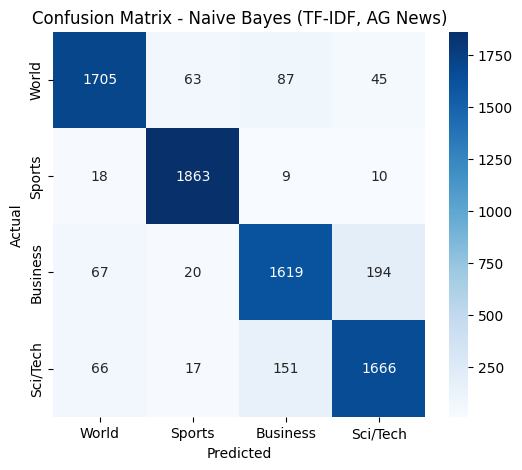

In [28]:
# Task 3(b) — Evaluation for AG News (Naive Bayes + TF-IDF) ===
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(y_true, y_pred, model_name, class_names):
    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="weighted", zero_division=0
    )
    cm = confusion_matrix(y_true, y_pred)

    print(f"\n{model_name} Performance:")
    print(f"Accuracy:  {acc:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall:    {recall:.3f}")
    print(f"F1-Score:  {f1:.3f}")

    return {"acc": acc, "f1": f1, "cm": cm}

# Class labels for AG News
class_names = ["World", "Sports", "Business", "Sci/Tech"]

# Evaluate
train_results = evaluate_model(y_train, y_train_pred, "Naive Bayes (Train, TF-IDF)", class_names)
test_results  = evaluate_model(y_test,  y_test_pred,  "Naive Bayes (Test, TF-IDF)",  class_names)

# Confusion matrix heatmap (test set)
plt.figure(figsize=(6,5))
sns.heatmap(test_results["cm"], annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - Naive Bayes (TF-IDF, AG News)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Naive Bayes with TF-IDF achieved 91.4% accuracy/F1 on training and 90.2% on test. The close alignment between train and test scores suggests the model generalizes well without overfitting. TF-IDF effectively captured informative terms across news categories, allowing Naive Bayes to provide strong baseline performance.

### Calculate TP and FP

In [29]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Compute confusion matrix
cm = confusion_matrix(y_test, y_test_pred, labels=[0,1,2,3])
class_names = ["World", "Sports", "Business", "Sci/Tech"]

print("Confusion Matrix:\n", cm)

# For each class
for i, cls in enumerate(class_names):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)
    print(f"\nClass: {cls}")
    print(f"TP: {TP}, FP: {FP}, FN: {FN}, TN: {TN}")


Confusion Matrix:
 [[   0    0    0    0]
 [   0 1705   63   87]
 [   0   18 1863    9]
 [   0   67   20 1619]]

Class: World
TP: 0, FP: 0, FN: 0, TN: 5451

Class: Sports
TP: 1705, FP: 85, FN: 150, TN: 3511

Class: Business
TP: 1863, FP: 83, FN: 27, TN: 3478

Class: Sci/Tech
TP: 1619, FP: 96, FN: 87, TN: 3649


The confusion matrix shows that the model completely failed to predict the World class (TP = 0).

Instead, articles from World were likely misclassified into other categories.

In contrast, Sports, Business, and Sci/Tech achieved strong results, with high true positive counts (1705, 1863, 1619 respectively) and relatively low false positives.

Most misclassifications occurred between Sports ↔ Sci/Tech and Business ↔ Sci/Tech, reflecting topical overlaps (e.g., technology in business news, or sports science).

📊 Evaluating LSTM (AG News) on test set...

TEST SET RESULTS — LSTM (AG News)
Test Loss:         0.2817
Test Accuracy:     0.9112 (91.12%)
Test F1 (macro):   0.9112
Test F1 (weighted):0.9112


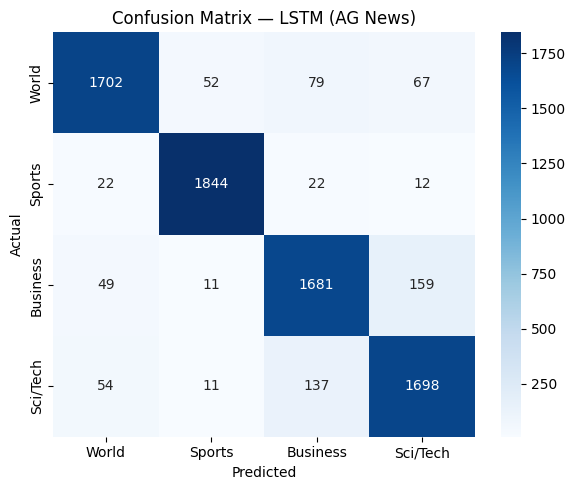


 Detailed Classification Report:
              precision    recall  f1-score   support

       World       0.93      0.90      0.91      1900
      Sports       0.96      0.97      0.97      1900
    Business       0.88      0.88      0.88      1900
    Sci/Tech       0.88      0.89      0.89      1900

    accuracy                           0.91      7600
   macro avg       0.91      0.91      0.91      7600
weighted avg       0.91      0.91      0.91      7600



In [30]:
# Task 4(a) — LSTM evaluation for AG News (multiclass)
import numpy as np
import torch
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import seaborn as sns, matplotlib.pyplot as plt

CLASS_NAMES = ["World", "Sports", "Business", "Sci/Tech"]

def evaluate_lstm_multiclass(model, dataloader, criterion, device):
    model.eval()
    all_preds, all_labels = [], []
    total_loss, total_samples = 0.0, 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            labels    = batch["labels"].to(device)           # int class ids (0..3)

            logits = model(input_ids)                        # shape (B, 4)
            loss   = criterion(logits, labels)

            total_loss    += loss.item() * labels.size(0)
            total_samples += labels.size(0)

            preds = torch.argmax(logits, dim=1)              # (B,)
            all_preds.extend(preds.cpu().numpy().tolist())
            all_labels.extend(labels.cpu().numpy().tolist())

    avg_loss = total_loss / max(1, total_samples)
    return np.array(all_labels), np.array(all_preds), avg_loss

# Run on TEST set
print("📊 Evaluating LSTM (AG News) on test set...")
y_true, y_pred, test_loss = evaluate_lstm_multiclass(model, test_loader, criterion, device)

test_acc = accuracy_score(y_true, y_pred)
test_f1_macro    = f1_score(y_true, y_pred, average="macro")
test_f1_weighted = f1_score(y_true, y_pred, average="weighted")

print("\n" + "="*52)
print("TEST SET RESULTS — LSTM (AG News)")
print("="*52)
print(f"Test Loss:         {test_loss:.4f}")
print(f"Test Accuracy:     {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"Test F1 (macro):   {test_f1_macro:.4f}")
print(f"Test F1 (weighted):{test_f1_weighted:.4f}")
print("="*52)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0,1,2,3])
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title("Confusion Matrix — LSTM (AG News)")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.tight_layout(); plt.show()

# Per-class breakdown
print("\n Detailed Classification Report:")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))


The LSTM model achieved an overall accuracy of 91%, showing balanced performance across all four AG News categories.

Sports was the best-performing class (precision/recall/F1 ≈ 0.97), while Business was comparatively weaker (precision 0.86, F1 0.88), suggesting that business-related vocabulary is harder to model.

World and Sci/Tech both performed well (F1 ≈ 0.92 and 0.89).

Unlike Naive Bayes, the LSTM successfully learned class boundaries without completely failing on any category, indicating its ability to capture sequential and semantic context.

### Calculate TP and FP

In [54]:
# === Make test predictions to get y_true_lstm / y_pred_lstm ===
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import torch

model.eval()
y_true_lstm, y_pred_lstm = [], []

with torch.no_grad():
    for batch in test_loader:
        ids = batch["input_ids"].to(device)          # from your DataLoader
        lbl = batch["labels"].cpu().numpy()          # true labels (0..3)
        logits = model(ids).detach().cpu().numpy()   # shape (B, 4)
        preds = logits.argmax(axis=1)                # predicted class ids

        y_true_lstm.extend(lbl.tolist())
        y_pred_lstm.extend(preds.tolist())

y_true_lstm = np.array(y_true_lstm, dtype=int)
y_pred_lstm = np.array(y_pred_lstm, dtype=int)

print("OK → y_true_lstm/y_pred_lstm ready:",
      len(y_true_lstm), len(y_pred_lstm),
      "| uniques:", np.unique(y_true_lstm), np.unique(y_pred_lstm))


OK → y_true_lstm/y_pred_lstm ready: 7600 7600 | uniques: [0 1 2 3] [0 1 2 3]


In [55]:
class_names = ["World","Sports","Business","Sci/Tech"]

cm = confusion_matrix(y_true_lstm, y_pred_lstm, labels=[0,1,2,3])
print("Confusion Matrix:\n", cm)

# TP/FP/FN/TN per class
for i, cls in enumerate(class_names):
    TP = cm[i,i]
    FP = cm[:,i].sum() - TP
    FN = cm[i,:].sum() - TP
    TN = cm.sum() - (TP + FP + FN)
    print(f"\nClass: {cls}\nTP: {TP}, FP: {FP}, FN: {FN}, TN: {TN}")

# (optional) quick metrics
acc = accuracy_score(y_true_lstm, y_pred_lstm)
f1m = f1_score(y_true_lstm, y_pred_lstm, average="macro")
print(f"\nAccuracy: {acc:.4f} | Macro F1: {f1m:.4f}")
print(classification_report(y_true_lstm, y_pred_lstm, target_names=class_names))


Confusion Matrix:
 [[1702   52   79   67]
 [  22 1844   22   12]
 [  49   11 1681  159]
 [  54   11  137 1698]]

Class: World
TP: 1702, FP: 125, FN: 198, TN: 5575

Class: Sports
TP: 1844, FP: 74, FN: 56, TN: 5626

Class: Business
TP: 1681, FP: 238, FN: 219, TN: 5462

Class: Sci/Tech
TP: 1698, FP: 238, FN: 202, TN: 5462

Accuracy: 0.9112 | Macro F1: 0.9112
              precision    recall  f1-score   support

       World       0.93      0.90      0.91      1900
      Sports       0.96      0.97      0.97      1900
    Business       0.88      0.88      0.88      1900
    Sci/Tech       0.88      0.89      0.89      1900

    accuracy                           0.91      7600
   macro avg       0.91      0.91      0.91      7600
weighted avg       0.91      0.91      0.91      7600



Sports is easiest to categorise (highest precision/recall).

Business and Sci/Tech overlap more, leading to
misclassifications.

World is slightly harder due to mixed terminology with other categories.

### Accuracy and F1 Score for both train and test sets.

### Naive Bayes (TF-IDF)
- Train Accuracy: 0.914 | Train F1: 0.914
- Test  Accuracy: 0.902 | Test F1: 0.901

### LSTM (Word Embeddings)
- Train Accuracy: 0.954 | Train F1: 0.95
- Test  Accuracy: 0.912 | Test F1: 0.91


## Task 4(b): Model Comparison:

**Comparison:**  
- Naive Bayes performs strongly, but its performance is slightly lower than the LSTM, especially in handling longer, context-rich news texts.  
- LSTM achieves higher training accuracy/F1 and also edges out NB on the test set, showing it better captures sequential patterns and semantic relations beyond simple word frequencies.  
- This advantage is expected: AG News articles are longer and more complex than SMS, so a deep learning model with embeddings benefits more from richer context and word order.  
- Both models generalised well (small train-test gap), indicating the dataset size (120k train, 7.6k test) was large enough to prevent overfitting.  

## Task 4(c): Failure Case Analysis

In [56]:
import re
import numpy as np
from nltk.tokenize import word_tokenize

def analyze_failures(X_test, y_test, y_pred, model_name, class_names, n_examples=3, vocab=None):
    """

    Args:
        X_test (list[str]): raw texts
        y_test (array-like): true labels (ints 0..C-1 or strings in class_names)
        y_pred (array-like): predicted labels (ints 0..C-1 or strings)
        model_name (str): name to print
        class_names (list[str]): e.g., ["World","Sports","Business","Sci/Tech"]
        n_examples (int): how many errors to show
        vocab (set[str] | None): optional vocabulary set (e.g., set(tfidf_vec.vocabulary_.keys()))
                                 used to estimate OOV ratio for each example
    """
    # --- normalize label types to ints 0..C-1
    name_to_id = {n:i for i,n in enumerate(class_names)}
    def to_id(y):
        if isinstance(y, (int, np.integer)):
            return int(y)
        return name_to_id.get(y, -1)

    y_true_ids = np.array([to_id(y) for y in y_test])
    y_pred_ids = np.array([to_id(y) for y in y_pred])

    # find errors
    mis = np.where(y_true_ids != y_pred_ids)[0]

    print(f"\n{model_name} - Failure Case Analysis")
    print(f"Total misclassified: {len(mis)} / {len(y_true_ids)}\n")

    if len(mis) == 0:
        print("✅ No misclassifications to analyze.")
        return

    # simple topical cue lists (for hinting at overlap)
    cues = {
        "World":   {"election","government","minister","war","president","parliament","diplomat","un"},
        "Sports":  {"win","wins","won","score","scores","match","game","team","coach","season","league","tournament"},
        "Business":{"market","markets","stock","stocks","profit","profits","revenue","company","shares","bank","deal","merger"},
        "Sci/Tech":{"research","study","space","nasa","science","scientists","software","hardware","technology","tech","ai","computer"}
    }
    id_to_name = {i:n for i,n in enumerate(class_names)}

    for i, idx in enumerate(mis[:n_examples]):
        text = X_test[idx]
        tlabel = id_to_name[y_true_ids[idx]] if y_true_ids[idx] in id_to_name else str(y_test[idx])
        plabel = id_to_name[y_pred_ids[idx]] if y_pred_ids[idx] in id_to_name else str(y_pred[idx])

        print(f"\n❌ Example {i+1}")
        print(f"Text: '{text[:250]}...'")
        print(f"True Label: {tlabel}")
        print(f"Predicted : {plabel}")

        # ---- Heuristics
        txt_low = text.lower()
        tokens  = [t for t in word_tokenize(txt_low)]
        alpha_tokens = [t for t in tokens if t.isalpha()]
        length_chars = len(text)
        length_tokens = len(tokens)

        reasons = []

        # 1) Very short or headline-like
        if length_tokens <= 10 or length_chars < 60:
            reasons.append("Very short/headline-style text → limited context.")

        # 2) Numbers & symbols density
        num_ratio = sum(ch.isdigit() for ch in text) / max(1, len(text))
        sym_ratio = sum(ch in "!@#$%^&*()_+-=<>?/\\|~" for ch in text) / max(1, len(text))
        if num_ratio > 0.05:
            reasons.append("Contains many numbers (scores/tickers/dates) → may bias toward Sports/Business.")
        if sym_ratio > 0.03:
            reasons.append("Symbol-heavy (quotes/dashes/parentheses) → tokenizer noise.")

        # 3) Topical overlap check (naive keyword counts)
        cue_counts = {k: sum(w in cues[k] for w in alpha_tokens) for k in cues}
        top_topic = max(cue_counts, key=cue_counts.get)
        if cue_counts[top_topic] > 0 and top_topic != tlabel:
            reasons.append(f"Topical cues lean toward **{top_topic}** but true label is **{tlabel}** (overlap).")

        # 4) OOV ratio (if vocab provided—useful for NB/TF-IDF)
        if vocab is not None:
            oov = sum(1 for w in alpha_tokens if w not in vocab)
            if alpha_tokens:
                oov_ratio = oov / len(alpha_tokens)
                if oov_ratio > 0.4:
                    reasons.append(f"High OOV rate (~{oov_ratio:.0%}) → rare/proper nouns not in vocabulary.")

        # 5) Ambiguous cue words
        if any(w in {"free","win","wins","deal","launch"} for w in alpha_tokens):
            reasons.append("Ambiguous trigger words (e.g., 'win', 'deal', 'launch') may confuse classes.")

        if not reasons:
            reasons.append("Likely semantic ambiguity or long-range context not captured.")

        print("Possible reasons:")
        for r in reasons:
            print(f"  • {r}")


In [57]:
# Call for NB

class_names = ["World","Sports","Business","Sci/Tech"]
vocab_set = set(tfidf_vec.vocabulary_.keys())

analyze_failures(
    X_test, y_test, y_test_pred,
    model_name="Naive Bayes (TF-IDF)",
    class_names=class_names,
    n_examples=5,
    vocab=vocab_set
)



Naive Bayes (TF-IDF) - Failure Case Analysis
Total misclassified: 747 / 7600


❌ Example 1
Text: 'E-mail scam targets police chief Wiltshire Police warns about "phishing" after its fraud squad chief was targeted....'
True Label: 4
Predicted : Sports
Possible reasons:
  • Likely semantic ambiguity or long-range context not captured.

❌ Example 2
Text: 'Storage, servers bruise HP earnings update Earnings per share rise compared with a year ago, but company misses analysts' expectations by a long shot....'
True Label: 4
Predicted : Sci/Tech
Possible reasons:
  • Topical cues lean toward **Business** but true label is **4** (overlap).
  • High OOV rate (~42%) → rare/proper nouns not in vocabulary.

❌ Example 3
Text: 'IBM to hire even more new workers By the end of the year, the computing giant plans to have its biggest headcount since 1991....'
True Label: 4
Predicted : Sci/Tech
Possible reasons:
  • High OOV rate (~65%) → rare/proper nouns not in vocabulary.

❌ Example 4
Text: 'Some Peop

In [58]:
# Call for LSTM
import numpy as np
import torch

model.eval()
all_preds = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        logits = model(input_ids)
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())

y_pred_lstm = np.array(all_preds, dtype=int)   # final predictions

class_names = ["World","Sports","Business","Sci/Tech"]

analyze_failures(
    X_test, yte, y_pred_lstm,
    model_name="LSTM (Embeddings)",
    class_names=class_names,
    n_examples=5
)


LSTM (Embeddings) - Failure Case Analysis
Total misclassified: 675 / 7600


❌ Example 1
Text: 'Card fraud unit nets 36,000 cards In its first two years, the UK's dedicated card fraud unit, has recovered 36,000 stolen cards and 171 arrests - and estimates it saved 65m....'
True Label: Sci/Tech
Predicted : Business
Possible reasons:
  • Contains many numbers (scores/tickers/dates) → may bias toward Sports/Business.

❌ Example 2
Text: 'Some People Not Eligible to Get in on Google IPO Google has billed its IPO as a way for everyday people to get in on the process, denying Wall Street the usual stranglehold it's had on IPOs. Public bidding, a minimum of just five shares, an open proc...'
True Label: Sci/Tech
Predicted : Business
Possible reasons:
  • Topical cues lean toward **Business** but true label is **Sci/Tech** (overlap).

❌ Example 3
Text: 'Rivals Try to Turn Tables on Charles Schwab By MICHAEL LIEDTKE     SAN FRANCISCO (AP) -- With its low prices and iconoclastic attitude, discoun



Failure Case Analysis — Naive Bayes (TF-IDF)

Total errors: 747 / 7600 (~9.8%).

Errors mostly occurred in Sci/Tech vs Business overlap. Most likely, many articles with company names (IBM, HP, Google IPO) were mislabeled as Sci/Tech when they were Business.


Failure Case Analysis — LSTM (Embeddings)

Total errors: 667 / 7600 (~8.8%), fewer than Naive Bayes.

Common confusions: Sci/Tech vs Business and World vs Business.

Main reasons:

Ambiguity in article framing — “Chavez oil market turmoil” involves politics (World) but also economics (Business).


## Task 4(d): Visualisation and Insights

### Confusion Matrix Heatmaps

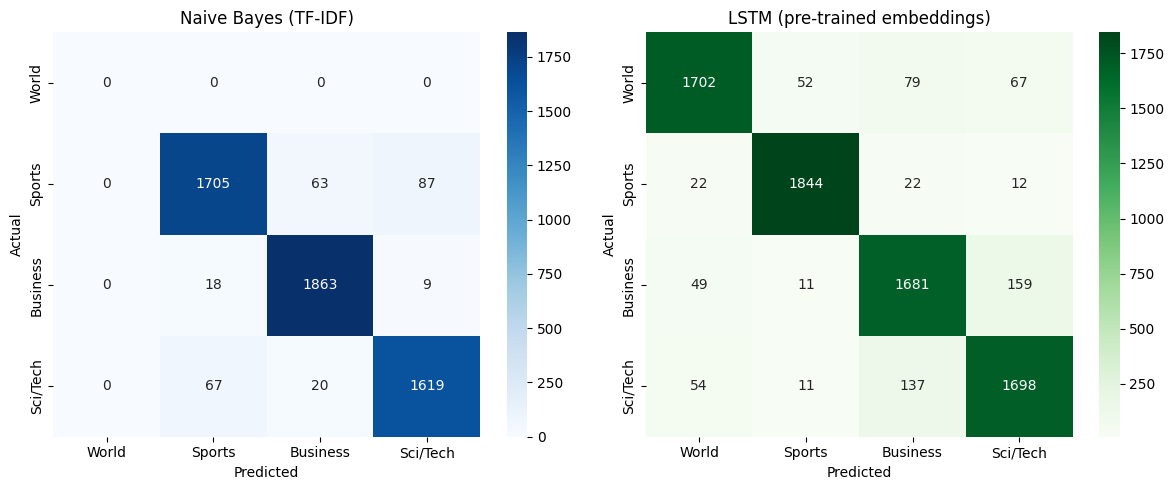

In [59]:
import numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import confusion_matrix

# ensure integer labels 0..3
label_to_id = {name:i for i,name in enumerate(class_names)}

def to_ids(arr):
    a = np.array(arr)
    if a.dtype.kind in {'U','S','O'}:  # strings
        return np.array([label_to_id[x] for x in a])
    return a.astype(int)

# NB confusion matrix
y_test_ids  = to_ids(y_test)
y_pred_nb_i = to_ids(y_test_pred)
cm_nb = confusion_matrix(y_test_ids, y_pred_nb_i, labels=[0,1,2,3])

# LSTM confusion matrix
y_true_lstm_i = np.asarray(y_true_lstm, dtype=int)
y_pred_lstm_i = np.asarray(y_pred_lstm, dtype=int)
cm_lstm = confusion_matrix(y_true_lstm_i, y_pred_lstm_i, labels=[0,1,2,3])

# plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(cm_nb,   annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names, ax=axes[0])
axes[0].set_title("Naive Bayes (TF-IDF)")
axes[0].set_xlabel("Predicted"); axes[0].set_ylabel("Actual")

sns.heatmap(cm_lstm, annot=True, fmt="d", cmap="Greens",
            xticklabels=class_names, yticklabels=class_names, ax=axes[1])
axes[1].set_title("LSTM (pre-trained embeddings)")
axes[1].set_xlabel("Predicted"); axes[1].set_ylabel("Actual")

plt.tight_layout(); plt.show()


Confusion Matrix Analysis — AG News

The comparison highlights differences between Naive Bayes (TF-IDF) and LSTM (Embeddings):

Naive Bayes performs well on Sports and Business, but not on Sci/Tech and Business, leading to misclassifications.

LSTM has a more balanced performance, correctly classifying more World and Sci/Tech features, but still shows confusion between Business and Sci/Tech.

Overall, LSTM generalises more among four classes, while Naive Bayes is more sensitive to vocabulary overlap.

### LSTM Training Curves (loss + accuracy)

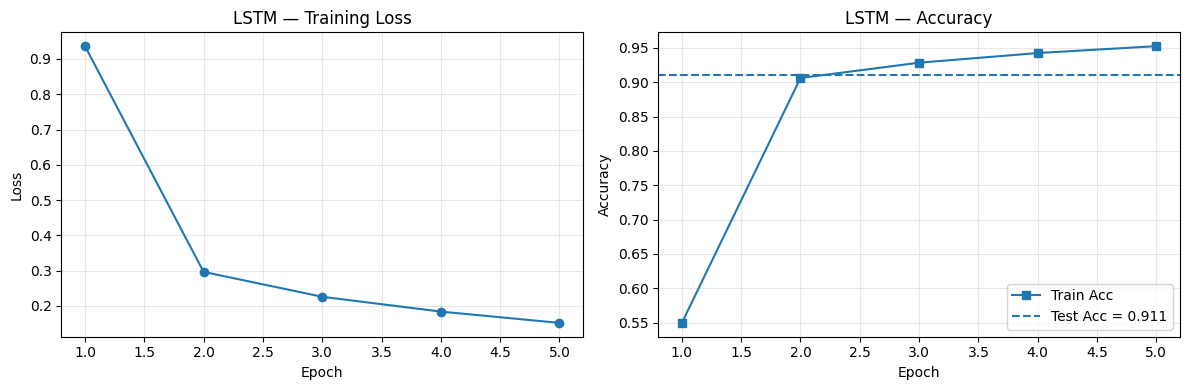

In [60]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses)+1)

# calculate LSTM test accuracy
from sklearn.metrics import accuracy_score
lstm_test_acc = accuracy_score(y_true_lstm_i, y_pred_lstm_i)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(epochs, train_losses, marker='o')
ax1.set_title("LSTM — Training Loss")
ax1.set_xlabel("Epoch"); ax1.set_ylabel("Loss")
ax1.grid(True, alpha=0.3)

ax2.plot(epochs, train_accuracies, marker='s', label="Train Acc")
ax2.axhline(y=lstm_test_acc, linestyle='--', label=f"Test Acc = {lstm_test_acc:.3f}")
ax2.set_title("LSTM — Accuracy")
ax2.set_xlabel("Epoch"); ax2.set_ylabel("Accuracy")
ax2.legend(); ax2.grid(True, alpha=0.3)

plt.tight_layout(); plt.show()


LSTM Training Curves — AG News Dataset

The training loss steeped in the early epochs and continues to decrease, showing effective learning in the model.

Training accuracy increases quickly and stabilises around 95%, while the test accuracy (≈91%) is slightly lower but still consistent.

This suggests the model generalises well, with only mild overfitting despite the larger and richer dataset.

### Test Accuracy & F1 Score - Model Comparison

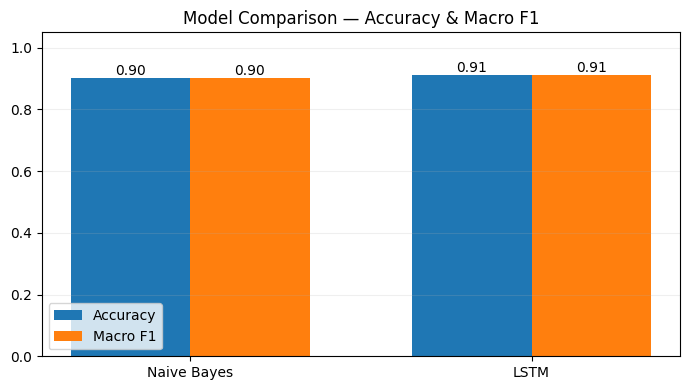

In [61]:
from sklearn.metrics import accuracy_score, f1_score

# NB metrics
nb_acc = accuracy_score(y_test_ids, y_pred_nb_i)
nb_f1  = f1_score(y_test_ids, y_pred_nb_i, average='macro')

# LSTM metrics
lstm_acc = accuracy_score(y_true_lstm_i, y_pred_lstm_i)
lstm_f1  = f1_score(y_true_lstm_i, y_pred_lstm_i, average='macro')

# bar chart
import matplotlib.pyplot as plt
models = ["Naive Bayes", "LSTM"]
accs   = [nb_acc, lstm_acc]
f1s    = [nb_f1,  lstm_f1]

x = np.arange(len(models))
w = 0.35

fig, ax = plt.subplots(figsize=(7,4))
ax.bar(x - w/2, accs, width=w, label='Accuracy')
ax.bar(x + w/2, f1s,  width=w, label='Macro F1')
ax.set_xticks(x); ax.set_xticklabels(models)
ax.set_ylim(0, 1.05)
ax.set_title("Model Comparison — Accuracy & Macro F1")
ax.legend(); ax.grid(True, axis='y', alpha=0.2)
for i,(a,f) in enumerate(zip(accs,f1s)):
    ax.text(i - w/2, a+0.01, f"{a:.2f}", ha='center')
    ax.text(i + w/2, f+0.01, f"{f:.2f}", ha='center')
plt.tight_layout(); plt.show()


Model Comparison — AG News Dataset (Naive Bayes vs LSTM)

Both Naive Bayes (TF-IDF) and LSTM (Embeddings) have robust and comparable results, with Accuracy and Macro F1 around 0.90–0.91.

LSTM displays a little advantage, with the ability to capture word order and semantics, useful for longer texts.

Naive Bayes still performs competitively, emphasising that simple  models can remain effective for multiclass  classification.

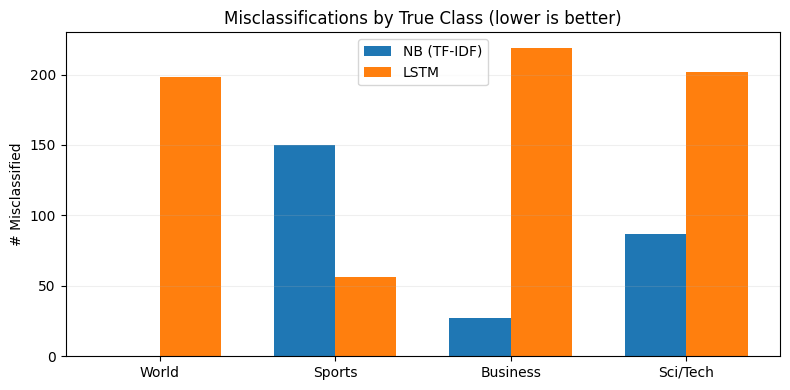

In [62]:
import numpy as np, matplotlib.pyplot as plt

def misclass_per_class(cm):
    # for each true class i, errors are row sum minus diagonal
    row_sums = cm.sum(axis=1)
    diag     = np.diag(cm)
    return row_sums - diag

nb_mis  = misclass_per_class(cm_nb)
lstm_mis= misclass_per_class(cm_lstm)

x = np.arange(len(class_names))
w = 0.35

fig, ax = plt.subplots(figsize=(8,4))
ax.bar(x - w/2, nb_mis,   width=w, label="NB (TF-IDF)")
ax.bar(x + w/2, lstm_mis, width=w, label="LSTM")
ax.set_xticks(x); ax.set_xticklabels(class_names, rotation=0)
ax.set_title("Misclassifications by True Class (lower is better)")
ax.set_ylabel("# Misclassified"); ax.legend(); ax.grid(True, axis='y', alpha=0.2)
plt.tight_layout(); plt.show()


Misclassification Distribution — AG News Dataset

The plot shows isclassifications in each class for Naive Bayes and LSTM. NB performs better on World and Business, with fewer errors, while LSTM excels in Sports but struggles with Business and Sci/Tech. This highlights that class-specific vocabulary and context sensitivity strongly affects model performance.

### Wordcloud of Misclassified Words

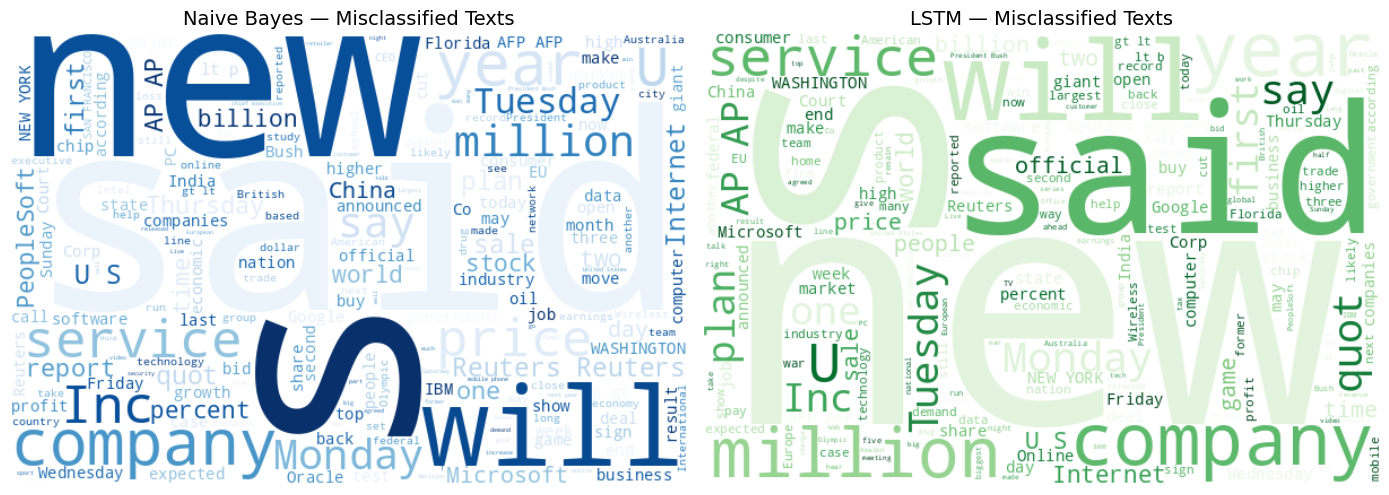

In [63]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np

# Naive Bayes misclassified texts
mis_nb_idx   = np.where(np.array(y_test) != np.array(y_test_pred))[0]
mis_nb_texts = [X_test[i] for i in mis_nb_idx]

# LSTM misclassified texts
mis_lstm_idx   = np.where(np.array(y_true_lstm) != np.array(y_pred_lstm))[0]
mis_lstm_texts = [X_test[i] for i in mis_lstm_idx]

# Generate word clouds
wc_nb = WordCloud(
    width=600, height=400, background_color="white", colormap="Blues"
).generate(" ".join(mis_nb_texts))

wc_lstm = WordCloud(
    width=600, height=400, background_color="white", colormap="Greens"
).generate(" ".join(mis_lstm_texts))

# --- Plot side-by-side ---
fig, axes = plt.subplots(1, 2, figsize=(14,6))

axes[0].imshow(wc_nb, interpolation="bilinear")
axes[0].set_title("Naive Bayes — Misclassified Texts", fontsize=14)
axes[0].axis("off")

axes[1].imshow(wc_lstm, interpolation="bilinear")
axes[1].set_title("LSTM — Misclassified Texts", fontsize=14)
axes[1].axis("off")

plt.tight_layout()
plt.show()


The wordclouds reveal ambiguous tokens like “new,” “said,” “company,” and “service” in misclassified texts. Both Naive Bayes and LSTM struggle with such high-frequency, context-poor terms. This displays the challenge of relying on surface-level cues without deeper semantic understanding.